# IRK schemes with Gauss-Legendre nodes

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-IRK8-(Fixed-step)">
             Integration with IRK8 (Fixed-step)</a></li>
             
<li><a href="#Integration-with-IRK8-(Adaptive-step)">
             Integration with IRK8 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRK,LinearAlgebra,Plots,Statistics
using DoubleFloats

  likely near /home/joseba/.julia/packages/IJulia/fXyGm/src/kernel.jl:52


<a href="#top">Back to the top</a>

## Initial value problem: Burrau problem

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [2]:
include("InitialBurrau.jl")
u0, Gm =InitialBurrau()
N = length(Gm)
size(u0)

(2, 3, 3)

Just to check that the output of the function NbodyODE has the expected type:

In [3]:
include("Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
@show size(du0);

size(du0) = (2, 3, 3)


In [4]:
t0 = 0.
T = 63. # Final time
T=10.
dt = 10^(-4) # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

<a href="#top">Back to the top</a>


## Integration with IRK8 (Fixed-step)

In [5]:
(sol0,iter0,steps0)=@time(solve(prob,IRK8(),dt=dt,saveat=dt,adaptive=false,myoutputs=true));

 13.614421 seconds (137.01 M allocations: 7.762 GiB, 17.71% gc time)


In [6]:
(length(sol0.t),mean(iter0[2:end]),sum(iter0[2:end]))

(100001, 3.09082, 309082)

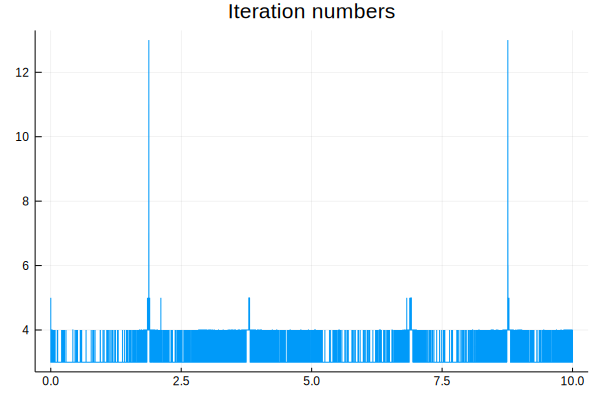

In [7]:
plot(sol0.t[2:end],iter0[2:end], title="Iteration numbers", legend=false)

## Integration with IRK8 (Adaptive-step)


### Retol=1e-12, abstol=1e-12

In [8]:
#T=63.
#tspan=(t0,T)
(sol1,iter1,steps1)=@time(solve(prob,IRK8(),dt=dt,saveat=dt,
                          reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  0.283524 seconds (2.55 M allocations: 146.532 MiB, 22.25% gc time)


In [9]:
(length(steps1),minimum(steps1[2:end]),mean(iter1),sum(iter1))

(296, 2.463368315203434e-5, 10.719594594594595, 3173)

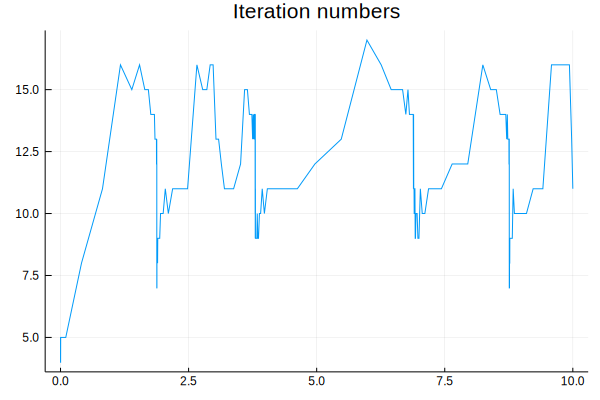

In [10]:
plot(sol1.t[2:end],iter1[2:end], title="Iteration numbers", legend=false)

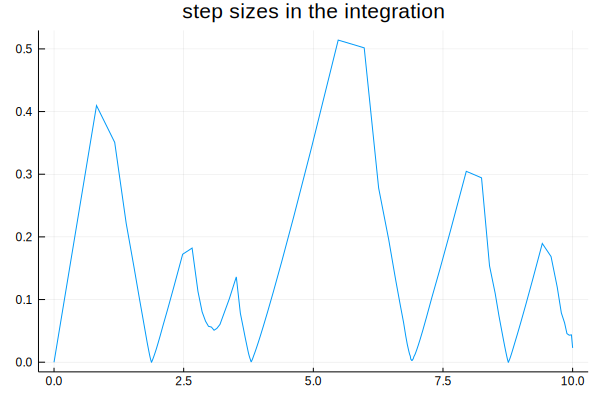

In [11]:
plot(sol1.t,steps1, title="step sizes in the integration", legend=false)

### Retol=1e-16, abstol=1e-16

In [12]:
(sol2,iter2,steps2)=@time(solve(prob,IRK8(),dt=dt,saveat=dt,
                          reltol=1e-16, abstol=1e-16,myoutputs=true,initial_interp=true));

  0.311184 seconds (3.23 M allocations: 183.222 MiB, 25.83% gc time)


In [13]:
(length(steps2),minimum(steps2[2:end]),mean(iter2),sum(iter2))

(520, 1.252137262374816e-5, 8.609615384615385, 4477)

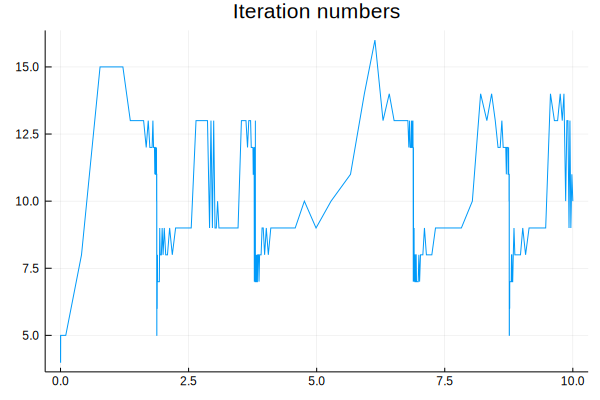

In [14]:
plot(sol2.t[2:end],iter2[2:end], title="Iteration numbers", legend=false)

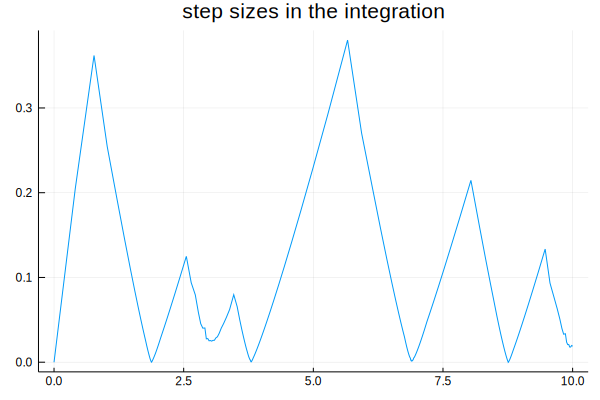

In [15]:
plot(sol2.t,steps2, title="step sizes in the integration", legend=false)

### Plots

In [16]:
bodylist = ["Body-1", "Body-2", "Body-3"]
ulist0 = sol0.u
tlist0 = sol0.t

pl1 = plot(title="Burrau problem (Fixed)",aspect_ratio=1)

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl1 = plot!(xlist,ylist, label = bodylist[j])   
end    


pl2 = plot(title="Burrau problem (Adaptive-1)",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl2 = plot!(xlist,ylist, label = bodylist[j])   
end  


#plot(pl)
plot(pl1,pl2,layout=2) 

In [17]:
plot(pl2)
savefig("Burrau.png")

<a href="#top">Back to the top</a>

## Error in energy

In [18]:
#setprecision(BigFloat, 128)
#u0128, Gm =InitialBurrau(BigFloat)
u0128, Gm =InitialBurrau(Double64)
(typeof(u0128),typeof(Gm))

(Array{Double64,3}, Array{Int64,1})

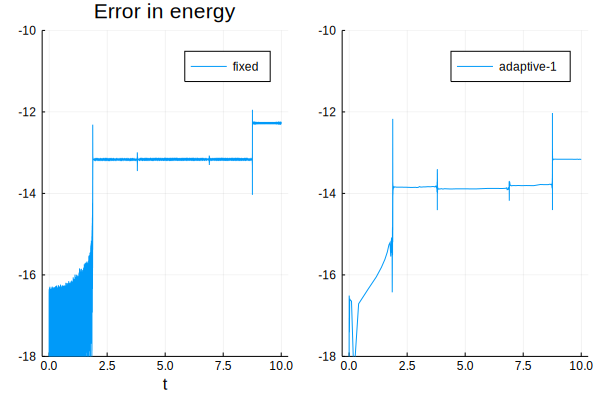

In [20]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(Double64.(sol0.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(Double64.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(Double64.(sol2.u[j]),Gm)/E0-1 for j in 1:length(tlist2)]


ylimit1=-18
ylimit2=-10

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)), 
    ylims=(ylimit1,ylimit2),
    xlabel="t", title="Error in energy", label="fixed")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
    ylims=(ylimit1,ylimit2),
    label="adaptive-1")
p3=plot(tlist2[1:end],log10.(abs.(EnergyErrors2)), 
    ylims=(ylimit1,ylimit2),
    label="adaptive-2")

plot(p1,p2,layout=2)